In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import folium
from folium.plugins import HeatMap

import branca.colormap

In [2]:
df = pd.read_csv('Collisions.csv', low_memory=False, parse_dates=["INCDATE"])
df["MONTH"] = df["INCDATE"].dt.month
df["YEAR"] = df["INCDATE"].dt.year

print(df.shape)
df.head()

(222581, 42)


,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,...,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,MONTH,YEAR
0,-122.315658,47.675815,1,330129,331629,EA22982,Matched,Intersection,24501.0,12TH AVE NE AND NE 65TH ST,...,Y,NaN,NaN,2,Vehicle turning left hits pedestrian,0,0,N,3,2020
1,-122.316780,47.608643,2,1288,1288,3476163,Matched,Block,NaN,12TH AVE BETWEEN E CHERRY ST AND E COLUMBIA ST,...,NaN,NaN,NaN,12,From same direction - both going straight - on...,0,0,N,3,2013
2,-122.344569,47.694547,3,1142,1142,3507856,Matched,Block,NaN,AURORA AVE N BETWEEN N 90TH ST AND N 91ST ST,...,NaN,NaN,NaN,13,From same direction - both going straight - bo...,0,0,N,3,2013
3,-122.365999,47.691729,4,330015,331515,C823869,Unmatched,Block,NaN,8TH AVE NW BETWEEN NW 86TH ST AND NW 87TH ST,...,NaN,NaN,NaN,,NaN,0,0,Y,8,2019
4,NaN,NaN,5,19800,19800,1060128,Matched,Block,NaN,ALASKAN WY VI NB BETWEEN S ROYAL BROUGHAM WAY ...,...,NaN,4358043.0,NaN,50,Fixed object,0,0,N,12,2004


#### Severity code
0 - unknown; 1 - only property damage; 2 - with injury; 2b - Serious injury; 3 - with fatality

In [3]:
len(np.where((df['SEVERITYCODE']=='0'))[0])

21781

## Collision hotspot monitoring
For each location, show the frequency of severe accidents (given a certain constrain), providing possibility to inspect interaction of factors led to severe collision.

In [4]:
def visualize_collision_freq(df_filtered, zoom_start=13):
    '''Utility function to overlay accident density.
    
    '''
    seattle_map = folium.Map(location=[df["Y"].mean(), df["X"].mean()],  
                             zoom_start=zoom_start, control_scale=True, min_zoom=10)
    HeatMap(data=df_filtered[["X","Y"]].groupby(['Y', 'X']).size().reset_index().values.tolist(), 
            radius=8, max_zoom=13).add_to(seattle_map)

    return seattle_map

### Fatal accident

In [5]:
df_filtered = df[(df["SEVERITYCODE"]=='3')]
seattle_map = visualize_collision_freq(df_filtered)
seattle_map

### Pedestrian related accident

In [6]:
df_filtered = df[(df["SEVERITYCODE"]=='2b') & (df['PEDCOUNT']>0)]
print('Total of ' + str(df[(df["SEVERITYCODE"]=='2b')].shape[0]) + ' serious injury, ' + 
      str(np.round(df_filtered.shape[0]/df[(df["SEVERITYCODE"]=='2b')].shape[0]*100,2)) +
       '% involving pedestrian.')
seattle_map = visualize_collision_freq(df_filtered, zoom_start=14)
seattle_map

Total of 3131 serious injury, 29.42% involving pedestrian.


### Bike related accident
With both the amount and severity of accidents.

In [7]:
# extract bike accidents 
df_cyc = df[df['PEDCYLCOUNT']>0]
df_filtered = df_cyc[(df_cyc['SEVERITYCODE']=='2') | 
                     (df_cyc['SEVERITYCODE']=='2b') | (df_cyc['SEVERITYCODE']=='3')]

# aggregate based on location of the accident
all_accidents = df_cyc[['X','Y','LOCATION']].groupby(['Y', 'X','LOCATION']).size().reset_index()
severe_accidents = df_filtered[['X','Y','LOCATION']].groupby(['Y', 'X', 'LOCATION']).size().reset_index()

# merge the two tables
merged_accidents = pd.merge(all_accidents, severe_accidents, how='inner', on=['X','Y','LOCATION'], left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_all', '_severe'), copy=True, indicator=False, validate=None)

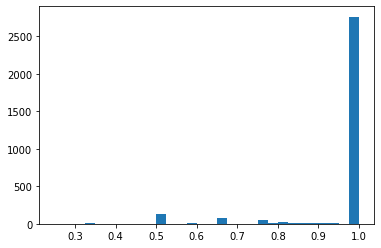

In [8]:
# include a column with severe accident ratio
merged_accidents['ratio'] = merged_accidents['0_severe']/merged_accidents['0_all']
plt.hist(merged_accidents['ratio'], 30);

In [9]:
min_ratio = .55 #0.0 #0.55
hot_spot = merged_accidents[(merged_accidents['ratio']>min_ratio) & (merged_accidents['ratio']<1)]
hot_spot

,Y,X,LOCATION,0_all,0_severe,ratio
59,47.668651,-122.393684,NW MARKET ST BETWEEN 28TH AVE NW AND NW 54TH ST,5,3,0.600000
71,47.668655,-122.392858,28TH AVE NW AND NW MARKET ST,3,2,0.666667
112,47.670916,-122.387587,24TH AVE NW AND NW 58TH ST,3,2,0.666667
116,47.671645,-122.387587,24TH AVE NW AND NW 59TH ST,4,3,0.750000
246,47.662390,-122.378894,17TH AVE NW AND SHILSHOLE AVE NW,3,2,0.666667
...,...,...,...,...,...,...
2966,47.578873,-122.283691,LAKE WASHINGTON BLVD S BETWEEN LAKE PARK DR S ...,9,6,0.666667
2968,47.605278,-122.283504,LAKE WASHINGTON BLVD BETWEEN E TERRACE ST AND ...,4,3,0.750000
3016,47.570021,-122.278349,LAKE WASHINGTON BLVD S BETWEEN 43RD AVE S AND ...,4,3,0.750000
3024,47.523312,-122.276403,RENTON AVE S AND S HENDERSON ST,5,3,0.600000


In [10]:
# use marker size and color to indicate total accident and severe ratio, respectively
def visualize_hotspot(hot_spot, min_ratio=0):
    colormap = branca.colormap.linear.YlOrRd_09.scale(0, 1)

    seattle_map = folium.Map(location=[hot_spot["Y"].mean(), hot_spot["X"].mean()], tiles='Stamen Toner', 
                             zoom_start=14, control_scale=True, min_zoom=10)
    colormap.add_to(seattle_map)

    for ind in range(hot_spot.shape[0]):
        folium.Circle(
            radius=int(np.log(hot_spot.iloc[ind]['0_all'])*50),#compress the change of size
            location=hot_spot.iloc[ind][['Y','X']],
            popup=hot_spot.iloc[ind]['LOCATION']+'; total: '+str(hot_spot.iloc[ind]['0_all'])+', with injury: '+str(hot_spot.iloc[ind]['0_severe']),
            color=colormap.rgb_hex_str((hot_spot.iloc[ind]['ratio']-min_ratio)*(1/(1-min_ratio))),
            fill=True,
        ).add_to(seattle_map)
    return seattle_map

In [11]:
seattle_map = visualize_hotspot(hot_spot, min_ratio=min_ratio)
seattle_map

In [12]:
# accidents along a certain street
street_name = r'\b12TH AVE'
street_accident = merged_accidents[(merged_accidents['LOCATION'].str.contains(
    street_name, na=False))]
seattle_map = visualize_hotspot(street_accident, min_ratio=0)
seattle_map

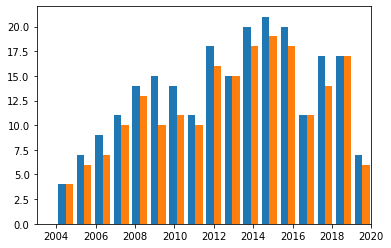

In [13]:
# How did the accidents distribution over the years
# street_name = r'\b2ND AVE'
plt.hist([df_cyc[(df_cyc['LOCATION'].str.contains(street_name, na=False))]['YEAR'],
         df_filtered[(df_filtered['LOCATION'].str.contains(street_name, na=False))]['YEAR']], 17);
plt.xlim([2003, 2020]);

## City planing policy evaluation
For example, are protected bike lanes effective? Resource on the type of bike lanes: http://seattlecitygis.maps.arcgis.com/apps/webappviewer/index.html?id=a24b25c3142c49e194190d6a888d97e3
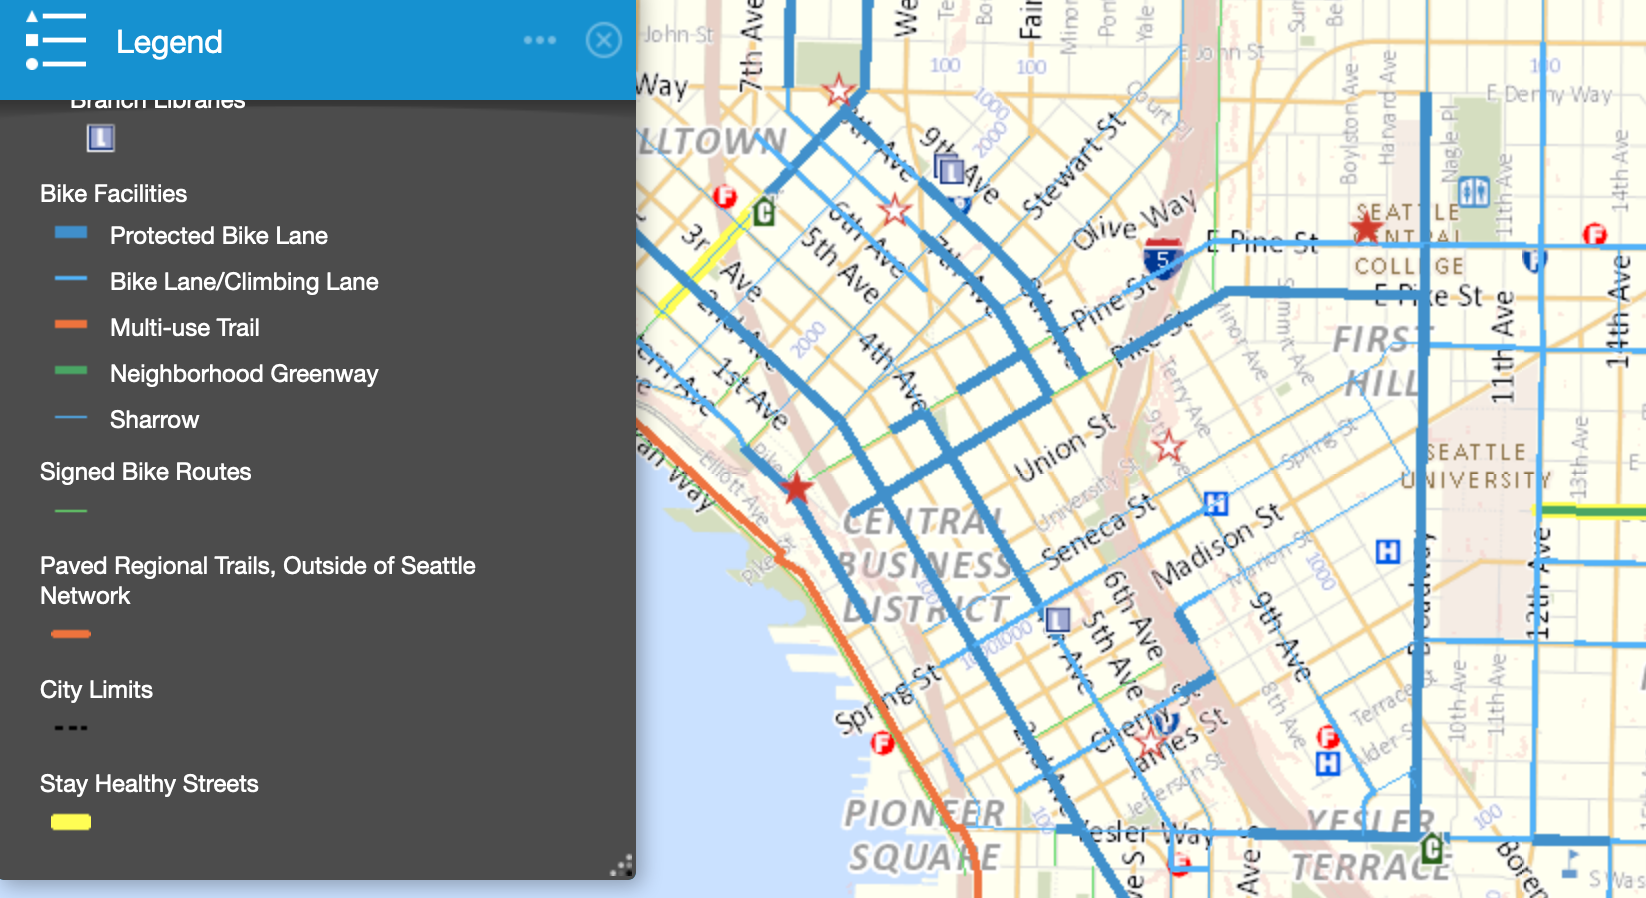
<!-- 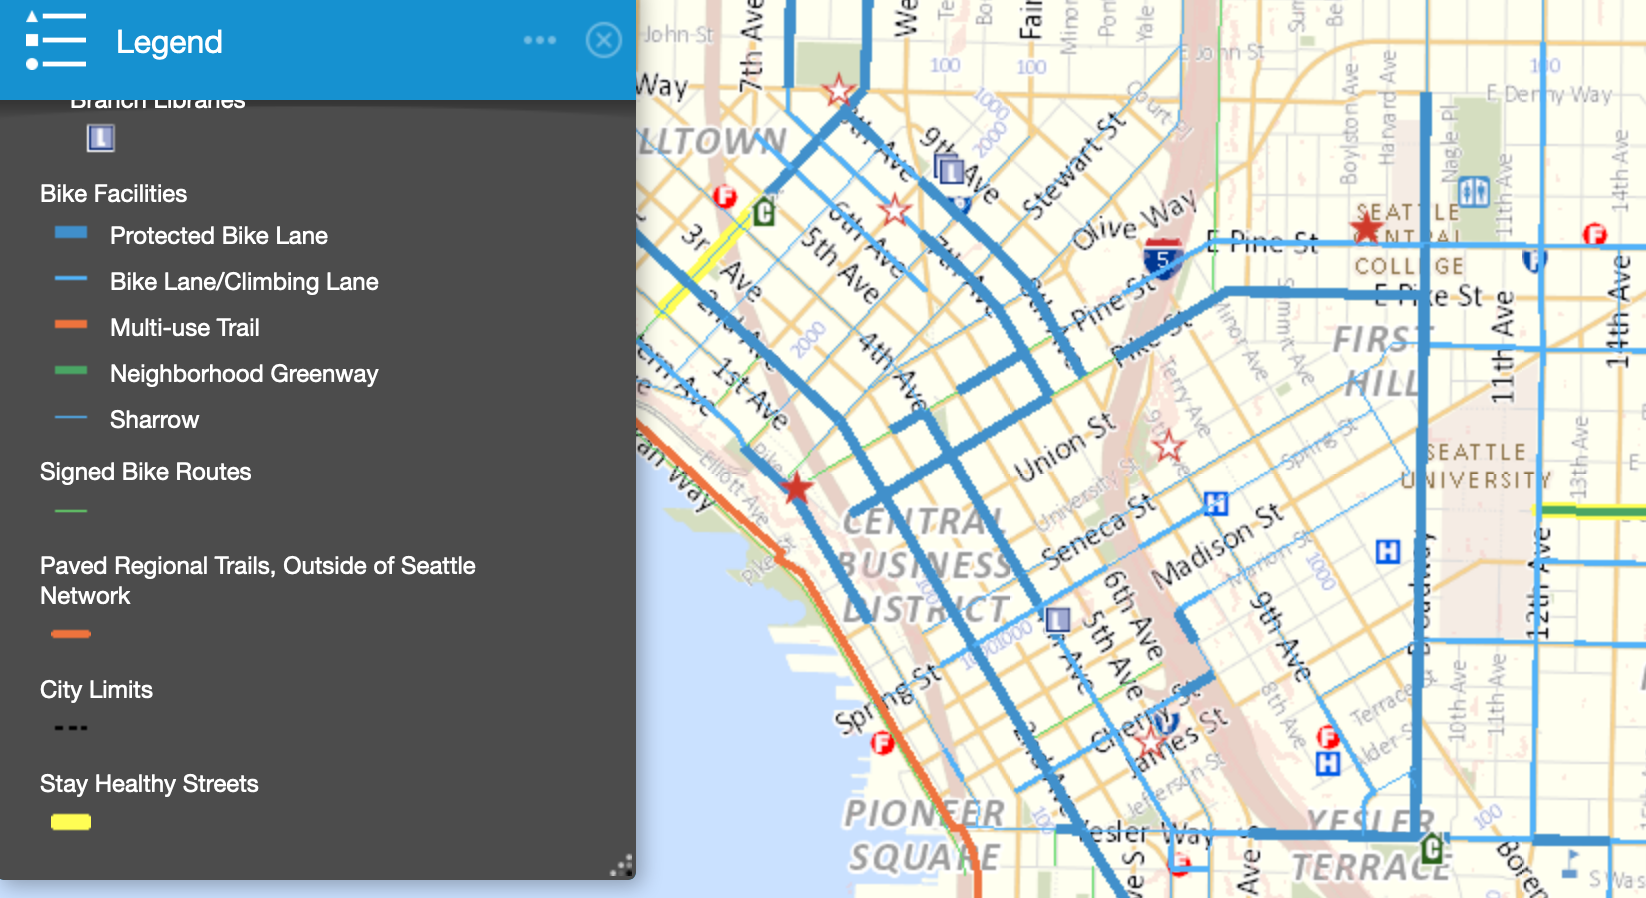 -->

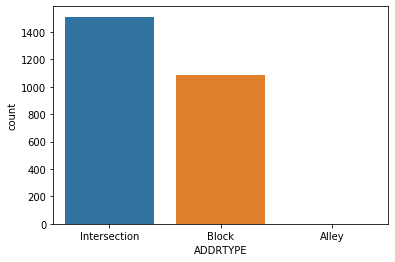

In [14]:
# more bike accidents happen at intersections
df_cyc['ADDRTYPE'].value_counts()
df_cyc_after2013 = df_cyc[df_cyc['YEAR']>2013]
sns.countplot(df_cyc_after2013['ADDRTYPE']);

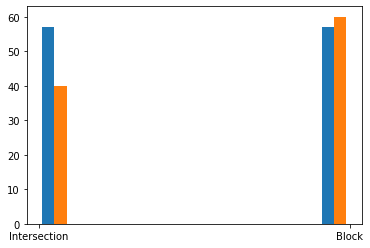

In [181]:
# SEATTLE protected bike lane projects started around 2014
df_cyc_before2014 = df_cyc[df_cyc['YEAR']<2014]

location_name = 'PIKE ST'
plt.hist([df_cyc_before2014[(df_cyc_before2014['LOCATION'].str.contains(location_name, na=False))]['ADDRTYPE'],
              df_cyc_after2013[df_cyc_after2013['LOCATION'].str.contains(location_name, na=False)]['ADDRTYPE']]);


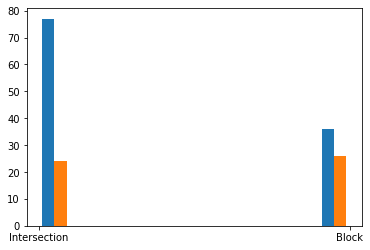

In [184]:
# bike accident ratio in terms of ADDRTYPE with/without the continued protected bike lanes
# compare a pair of neighboring routes
location_name = '12TH AVE'
location_name_pbl = 'BROADWAY'
plt.hist([df_cyc_after2013[(df_cyc_after2013['LOCATION'].str.contains(location_name, na=False))]['ADDRTYPE'],
              df_cyc_after2013[(df_cyc_after2013['LOCATION'].str.contains(location_name_pbl, na=False))]['ADDRTYPE']]);

In [19]:
street_with_protected_bike_lane = [r'\b2ND AVE', r'\b4TH AVE', r'\b7TH AVE', r'\b8TH AVE', r'\b9TH AVE N',
                                   'BROADWAY', 'PIKE ST', 'BELL ST', 'S DEARBORN ST', 
                                   'DEXTER AVE N', 'ROOSEVELT WAY NE']

In [16]:
ave_ratio = df_cyc_after2013['ADDRTYPE'].value_counts()['Intersection']/df_cyc_after2013.shape[0]

In [20]:
pbl_intersect_ratio = {}
for location_name in street_with_protected_bike_lane:
    tmp = df_cyc_after2013[(df_cyc_after2013['LOCATION'].str.contains(location_name, na=False))]
    pbl_intersect_ratio[location_name] = tmp['ADDRTYPE'].value_counts()['Intersection']/tmp.shape[0]
pbl_intersect_ratio

{'\\b2ND AVE': 0.5391304347826087,
 '\\b4TH AVE': 0.4383561643835616,
 '\\b7TH AVE': 0.423728813559322,
 '\\b8TH AVE': 0.4897959183673469,
 '\\b9TH AVE N': 0.6666666666666666,
 'BROADWAY': 0.48,
 'PIKE ST': 0.4,
 'BELL ST': 0.3333333333333333,
 'S DEARBORN ST': 0.5384615384615384,
 'DEXTER AVE N': 0.4605263157894737,
 'ROOSEVELT WAY NE': 0.5176470588235295}

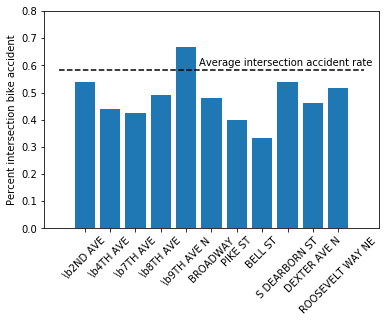

In [24]:
plt.bar(pbl_intersect_ratio.keys(), pbl_intersect_ratio.values());
plt.plot([-1, len(street_with_protected_bike_lane)],[ave_ratio, ave_ratio], 'k--'); 
plt.ylim([0, .8])
plt.ylabel('Percent intersection bike accident')
plt.text(4.5, 0.6,'Average intersection accident rate')
plt.xticks(rotation=45);
# plt.savefig('intersection_bike_accident_exp.pdf', bbox_inches='tight')